### Step 1: EDA on Training Labels (is_high_risk)

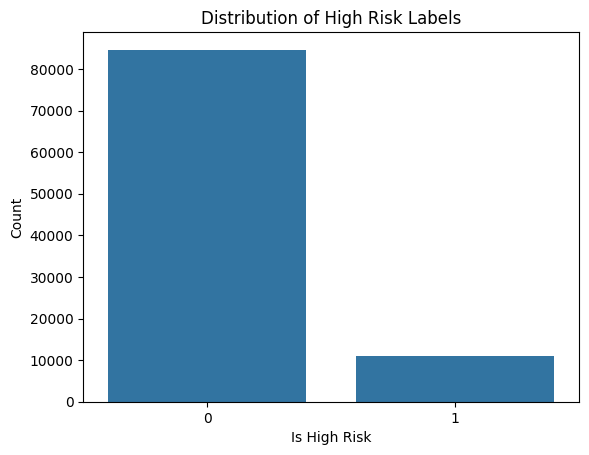

is_high_risk
0    0.884656
1    0.115344
Name: proportion, dtype: float64


In [38]:
# 1) SETUP -----------------------------------------------------------------
import sys, os

# Add the parent directory (project root) to Python’s module search path
sys.path.insert(0, os.path.abspath('..'))


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from src.model import split_data, evaluate_model, tune_hyperparameters

df = pd.read_csv("../data/processed/features_with_labels.csv")

# Count plot of the target variable
sns.countplot(data=df, x='is_high_risk')
plt.title("Distribution of High Risk Labels")
plt.xlabel("Is High Risk")
plt.ylabel("Count")
plt.show()

# Print proportion of each class
print(df['is_high_risk'].value_counts(normalize=True))


### Interpretation:
- is_high_risk = 1: Customer is flagged as high risk based on their fraud ratio (from previous logic).

- This plot shows class imbalance (most customers are low risk), which is common in fraud detection tasks.

### 📊 Step 2: Understand Features Used for Training
Your features include:

- Numerical Features (num__): Scaled values like transaction amount, average amount, standard deviation, hour of day, etc.

- Categorical Features (cat__): One-hot encoded categories (like product type, provider, country).

- Target: is_high_risk

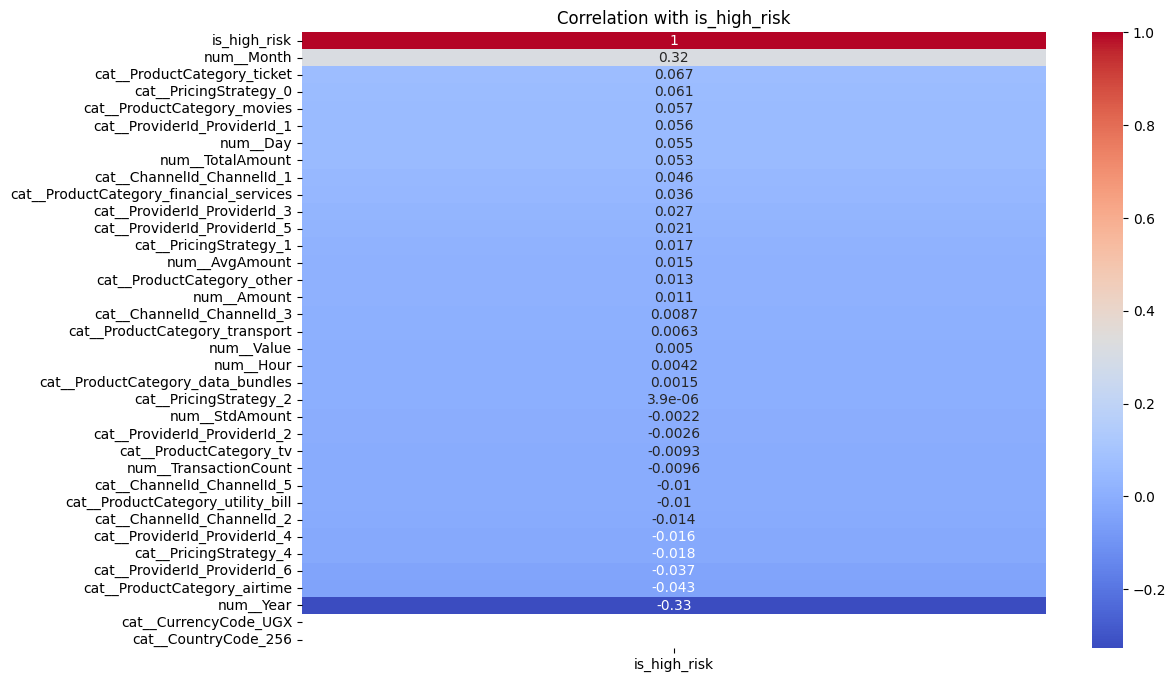

In [39]:
# Correlation heatmap
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr[['is_high_risk']].sort_values(by='is_high_risk', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation with is_high_risk")
plt.show()


### Key Features to Watch:
num__TotalAmount or num__TransactionCount: High fraud count often comes from active users.

cat__ProductCategory_*: Some product types may be riskier.

num__Hour, num__Day: Time patterns can be indicative of fraudulent behavior.

### 🧠 Step 3: Model Choices – Which and Why?
#### ✅ Logistic Regression
- Definition: A linear model that predicts the probability of binary classes.

- Pros:

        Interpretable coefficients.

        Fast and easy to regularize.

- Cons:

        Assumes linear separability.

        Why use it: Good baseline model; can highlight which features contribute most to risk.

#### 🌲 Random Forest
- Definition: An ensemble of decision trees using bootstrapped datasets and random feature subsets.

- Pros:

        Handles non-linear relationships well.

        Resistant to overfitting (compared to single trees).

        Automatically handles interactions and feature importance.

- Cons:

        Slower to train.

        Less interpretable.

        Why use it: Great for complex fraud patterns, handles categorical and numerical data well.

- Other potential models:

    Gradient Boosting (e.g., XGBoost): Even stronger performer, slower but more accurate.

### Step 4: Model Training 

#### 1. Load and Prepare Data

In [40]:
df = pd.read_csv("../data/processed/features_with_labels.csv")

X = df.drop(columns=['CustomerId', 'is_high_risk'])  # Features
y = df['is_high_risk']  # Target


#### 2. Split Data

In [41]:
from src.model import split_data
X_train, X_test, y_train, y_test = split_data(X, y)


#### Define Models and Hyperparameters

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), {
        "C": [0.01, 0.1, 1, 10]
    }),
    "RandomForest": (RandomForestClassifier(), {
        "n_estimators": [50, 100],
        "max_depth": [None, 10, 20]
    })
}


- `C` in logistic regression controls regularization (inverse of strength).

- `n_estimators`: number of trees in Random Forest.

- `max_depth`: limits complexity of trees to avoid overfitting.

#### 4. Model Training & Experiment Tracking

In [43]:
import mlflow
from src.model import tune_hyperparameters, evaluate_model

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("FraudDetection")

for name, (model, params) in models.items():
    with mlflow.start_run(run_name=name):
        best_model, best_params = tune_hyperparameters(model, params, X_train, y_train)

        mlflow.log_params(best_params)
        metrics = evaluate_model(best_model, X_test, y_test)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="model",
                registered_model_name="credit_fraud_model" 
)


        print(f"{name} Metrics:\n", metrics)
        print("Tracking URI:", mlflow.get_tracking_uri())


2025/07/24 18:14:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/24 18:14:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'credit_fraud_model' already exists. Creating a new version of this model...
2025/07/24 18:14:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: credit_fraud_model, version 3
Created version '3' of model 'credit_fraud_model'.


LogisticRegression Metrics:
 {'Accuracy': 0.8879945643652328, 'Precision': 0.6313131313131313, 'Recall': 0.05694760820045558, 'F1 Score': 0.10447137484329294, 'ROC AUC': np.float64(0.8232309123640257)}
Tracking URI: http://localhost:5000
🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/1/runs/b006d98c1b184f9ebf6e5159b740baab
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/07/24 18:14:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/24 18:14:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'credit_fraud_model' already exists. Creating a new version of this model...
2025/07/24 18:14:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: credit_fraud_model, version 4
Created version '4' of model 'credit_fraud_model'.


RandomForest Metrics:
 {'Accuracy': 0.9468980295823969, 'Precision': 0.8100999473961074, 'Recall': 0.7015945330296127, 'F1 Score': 0.751953125, 'ROC AUC': np.float64(0.9533829528622543)}
Tracking URI: http://localhost:5000
🏃 View run RandomForest at: http://localhost:5000/#/experiments/1/runs/5be1198d712242ee8055f78cd315e0c8
🧪 View experiment at: http://localhost:5000/#/experiments/1


- Here’s what happens:

        tune_hyperparameters: Grid search or random search on params.

        Best model is logged using MLflow.

        Metrics like accuracy, precision, recall, F1, and ROC-AUC are tracked.

        input_example logs the input format for reproducibility.

| Metric    | Logistic Regression     | Random Forest |
| --------- | ----------------------- | ------------- |
| Accuracy  | **0.888**               | **0.948** ✅   |
| Precision | 0.631                   | **0.817** ✅   |
| Recall    | **0.057** 🔻 (very low) | **0.701** ✅   |
| F1 Score  | 0.104                   | **0.755** ✅   |
| ROC AUC   | 0.823                   | **0.954** ✅   |
